## Load data

In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_feather('../data/spotify_2000_2020.feather')

# Define binary target for hits
df['is_hit'] = (df['popularity'] > 80).astype(int)


## Causal DAG: Visualizing Assumptions for Danceability → Popularity

**Objective:**  
Before estimating the causal effect of danceability on popularity, we define our assumptions using a **causal DAG (Directed Acyclic Graph)**.

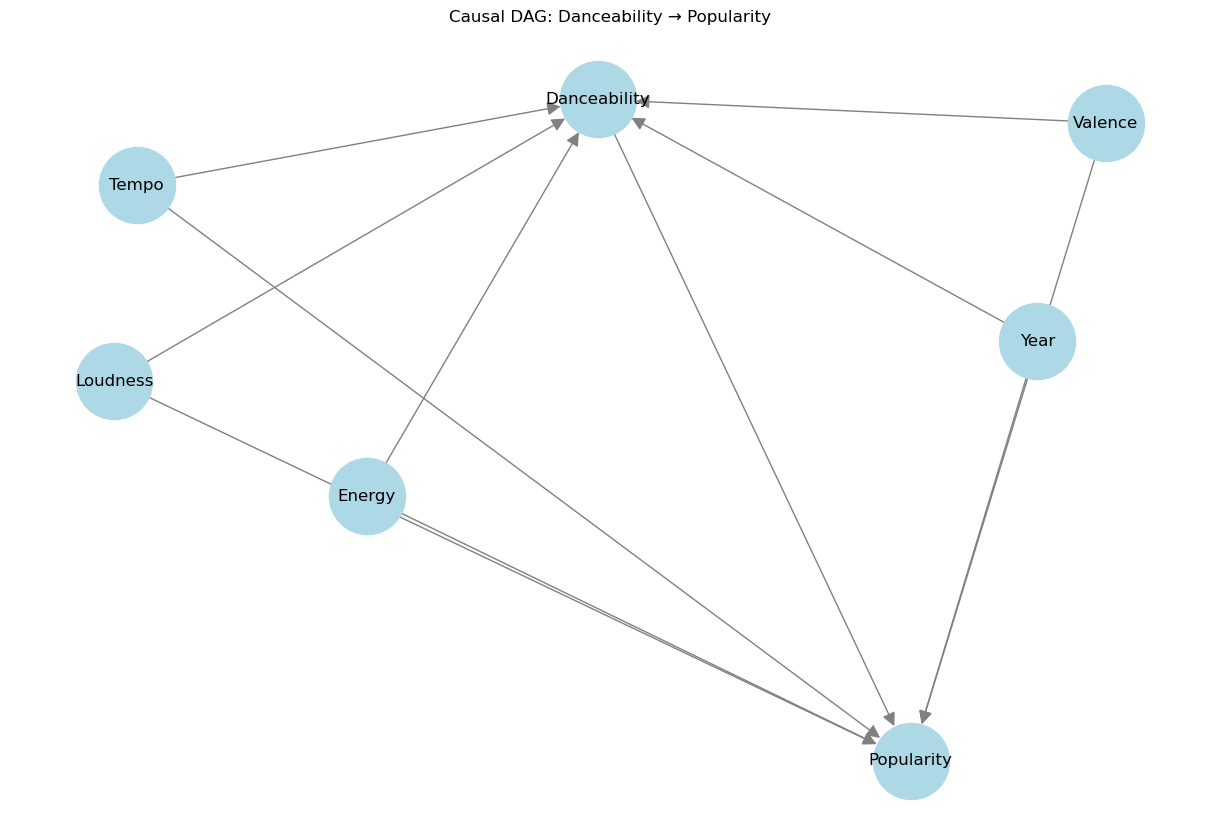

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
nodes = ["Danceability", "Popularity", "Energy", "Loudness", "Valence", "Tempo", "Year"]
G.add_nodes_from(nodes)

# Add edges (causal assumptions)
edges = [
    ("Danceability", "Popularity"),
    ("Energy", "Danceability"), ("Energy", "Popularity"),
    ("Loudness", "Danceability"), ("Loudness", "Popularity"),
    ("Valence", "Danceability"), ("Valence", "Popularity"),
    ("Tempo", "Danceability"), ("Tempo", "Popularity"),
    ("Year", "Danceability"), ("Year", "Popularity")
]
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, arrowsize=20)
plt.title("Causal DAG: Danceability → Popularity")
plt.show()


**Why?**  
We want to ensure we're accounting for **confounding variables** — factors that influence both danceability and popularity — so that we can isolate the true causal impact of danceability.

**Causal Question:**  
> *Does increasing a song’s danceability lead to higher popularity?*

To answer this, we visualize the assumed relationships between variables:

- **Treatment**: Danceability
- **Outcome**: Popularity
- **Confounders**: Energy, Loudness, Valence, Tempo, Year

These confounders:
- Affect both the treatment (danceability) and the outcome (popularity)
- Must be **adjusted for** to block **backdoor paths** and avoid biased estimates

We will use this DAG to justify which variables we include in **propensity score matching**, ensuring our causal estimate is as unbiased as possible.

## PSM (Propensity Score Matching)
It tries to simulate a randomized experiment by finding songs that are similar in all other features, except for danceability (the treatment).

In this context:

- Treatment group = songs with high danceability

- Control group = songs with lower danceability

- You match them based on confounders: energy, loudness, valence, tempo, year

### Step 1: Create Treatment Variable

In [5]:
# Define treatment: high danceability = top 25%
dance_threshold = df['danceability'].quantile(0.75)
df['treatment'] = (df['danceability'] > dance_threshold).astype(int)

# Outcome
df['outcome'] = df['popularity']


### Step 2: Estimate Propensity Scores with Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

# Select confounders
confounders = ['energy', 'valence', 'loudness', 'tempo', 'year']

# Fit logistic regression to estimate propensity scores
logit = LogisticRegression(max_iter=1000)
logit.fit(df[confounders], df['treatment'])

# Save the propensity scores
df['propensity_score'] = logit.predict_proba(df[confounders])[:, 1]

# Preview
df[['treatment', 'propensity_score']].head()


,treatment,propensity_score
0,0,0.032597
1,1,0.425332
2,0,0.151703
3,0,0.066990
4,0,0.048167


We used logistic regression to estimate the **propensity score** — the probability that a song has high danceability, given its energy, valence, loudness, tempo, and release year.

These scores represent how “comparable” treated (high danceability) and control (lower danceability) songs are based on confounders.

Example values:
- A song with a score of **0.03** is unlikely to be in the high-danceability group.
- A song with a score of **0.42** has a relatively high chance of being in the treatment group.

> We will now use these scores to **match** songs from the treatment and control groups with similar propensity, creating a balanced comparison set for estimating the causal effect of danceability on popularity.

### Step 3: Propensity Score Matching (Nearest Neighbor)

In [7]:
from sklearn.neighbors import NearestNeighbors

# Separate treated and control groups
treated = df[df['treatment'] == 1].copy()
control = df[df['treatment'] == 0].copy()

# Fit NearestNeighbors on control group
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])

# Find nearest control for each treated unit
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()].copy()

# Combine matched pairs into one dataset
matched_df = pd.concat([treated, matched_control])

# Reset index
matched_df.reset_index(drop=True, inplace=True)

# Preview
matched_df[['treatment', 'propensity_score', 'outcome']].head()


,treatment,propensity_score,outcome
0,1,0.425332,51.0
1,1,0.149903,46.0
2,1,0.506569,39.0
3,1,0.384917,39.0
4,1,0.417838,42.0


We matched each song in the **treatment group** (high danceability) with a similar song from the **control group** (lower danceability) using their **propensity scores**.

- Matching was done using **nearest-neighbor** search in 1:1 fashion.
- Matched songs had similar values for confounders (energy, valence, loudness, tempo, year), but differed in **danceability**.
- The resulting dataset (`matched_df`) now has an equal number of treated and control songs, ready for a fair causal comparison.

> We will now compare the **average popularity** between these two groups to estimate the **causal effect** of danceability on popularity.

## Step 4: Estimate the Treatment Effect

In [8]:
# Split matched data back into groups
treated_matched = matched_df[matched_df['treatment'] == 1]
control_matched = matched_df[matched_df['treatment'] == 0]

# Calculate Average Treatment Effect (ATE)
ate = treated_matched['outcome'].mean() - control_matched['outcome'].mean()

print(f"Estimated Average Treatment Effect (ATE): {ate:.2f}")


Estimated Average Treatment Effect (ATE): 1.28


The **Average Treatment Effect (ATE)** is **+1.28 popularity points**.

This means that, after controlling for confounding variables using Propensity Score Matching:
- Songs with high danceability are, on average, **1.28 points more popular** than similar songs with lower danceability.
- This difference is likely **causal**, not just correlational — it reflects the estimated effect of increasing a song’s danceability while holding other features constant.

> This suggests that boosting danceability may have a **real, measurable impact** on popularity — an insight relevant to product and content teams.

### Step 5: Bar Chart of Average Popularity (Treated vs. Control)

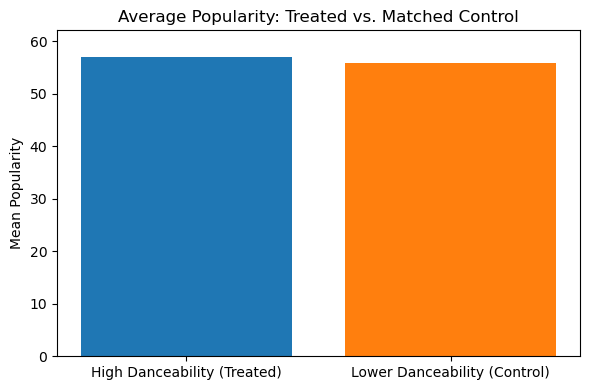

In [12]:
# Values and labels
x_labels = ['High Danceability (Treated)', 'Lower Danceability (Control)']
y_values = [avg_pop_treated, avg_pop_control]
colors = ['#1f77b4', '#ff7f0e']  # Blue and orange

# Plot
plt.figure(figsize=(6, 4))
for i in range(len(x_labels)):
    plt.bar(x_labels[i], y_values[i], color=colors[i])

plt.title('Average Popularity: Treated vs. Matched Control')
plt.ylabel('Mean Popularity')
plt.ylim(0, max(y_values) + 5)
plt.tight_layout()
plt.show()



This bar chart compares the **average popularity** of:
- **High danceability songs** (treated group)
- **Matched lower danceability songs** (control group)

- The **treated group** shows a **1.28 point increase in average popularity**, even after matching on confounding variables.
- This visual reinforces the estimated **causal effect** from our Propensity Score Matching:  
  > *Boosting a song’s danceability is likely to cause a measurable increase in popularity.*

This is a key finding for content teams, music recommendation models, and product decisions related to music feature engineering.